# --------------------------------------------
# Sleep Duration Prediction - Full ML Workflow
# --------------------------------------------

# 📦 Importing libraries

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
from scipy import stats

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [8]:
from sklearn.compose import ColumnTransformer

In [9]:
from sklearn.impute import SimpleImputer

In [10]:
from sklearn.decomposition import PCA

In [11]:
from sklearn.feature_selection import SelectKBest, f_regression

In [12]:
from sklearn.pipeline import Pipeline

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [14]:
from sklearn.metrics import mean_absolute_error, r2_score

In [15]:
import joblib

# --------------------------------------------
# 1. Reading Data
# --------------------------------------------

In [16]:
df = pd.read_csv('data.csv')

# --------------------------------------------
# 2. Exploring Data / Data Insight
# --------------------------------------------

In [17]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [19]:
df.isnull().sum()

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64

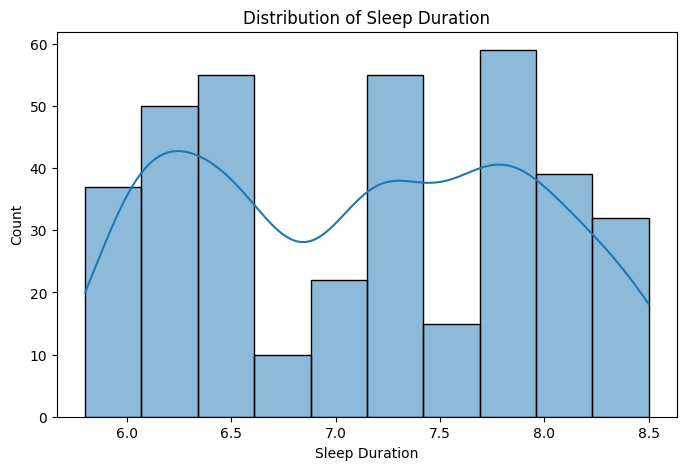

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(df['Sleep Duration'], kde=True)
plt.title('Distribution of Sleep Duration')
plt.show()

# -------------------------------------------
# 3. Cleansing Data
# -------------------------------------------
# Drop rows with missing Sleep Duration

In [21]:
df = df.dropna(subset=['Sleep Duration'])

# Optional: Fill missing numeric values with median

In [22]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

print("\n✅ Cleansing Done.")


✅ Cleansing Done.


# --------------------------------------------
# 4. Outlier Detection and Removing (Z-Score Method)
# --------------------------------------------

In [23]:
z = np.abs(stats.zscore(df[num_cols]))
df = df[(z < 3).all(axis=1)]

print("\n✅ Outliers Removed.")


✅ Outliers Removed.


# --------------------------------------------
# 5. Data Transformation (Normalize Data / Rescale Data)
# (Will apply StandardScaler inside pipeline)
# --------------------------------------------

### We'll not apply scaling manually here, but rather include it in the pipeline later.
### This ensures consistent transformation during training and inference.

In [24]:

print("\nℹ️ Data will be scaled using StandardScaler in pipeline.")



ℹ️ Data will be scaled using StandardScaler in pipeline.


# ------------------------------------------
# 6. Categorical into Numerical
# ------------------------------------------
### Get object (categorical) columns

In [25]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

# One-hot encode all categorical columns, drop first to avoid multicollinearity

In [26]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [27]:
print("\n✅ One-hot Encoding Applied.")
print(f"🔢 Final number of features: {df_encoded.shape[1]}")


✅ One-hot Encoding Applied.
🔢 Final number of features: 43


# ------------------------------------------
# 7. Dimensionality Reduction (PCA)
# (PCA will be part of pipeline later, AFTER scaling and feature selection)
# ------------------------------------------

In [28]:
print("\nℹ️ PCA will be applied after feature selection in pipeline.")


ℹ️ PCA will be applied after feature selection in pipeline.


# -------------------------------------------
# 8. Handling Imbalanced Data
# -------------------------------------------
# ⚠️ Since Sleep Duration is a continuous numerical target (regression),
# there is **no concept of class imbalance** as in classification tasks.
# So, we do NOT apply SMOTE or resampling.

In [29]:
print("\n✅ No imbalance handling needed for regression task.")


✅ No imbalance handling needed for regression task.


# ------------------------------------------
# 9. Feature Selection
# ------------------------------------------
# Feature selection will be done using SelectKBest with f_regression
# This will also be included in the pipeline.


In [30]:
print("\nℹ️ Feature selection (SelectKBest) will be done inside pipeline.")


ℹ️ Feature selection (SelectKBest) will be done inside pipeline.


# ---------------------------------------
# 10. Data Splitting
# ---------------------------------------

In [31]:
X = df.drop('Sleep Duration', axis=1)
y = df['Sleep Duration']

# Split BEFORE any feature selection or PCA

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# -----------------------------------------
# 🔥 Full Pipeline
# -----------------------------------------

In [33]:
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression, k=20)),  # Choose top 20 features
    ('pca', PCA(n_components=10))  # Then reduce dimensions to 10 PCs
])

# Pipelines for models

In [34]:
rf_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', RandomForestRegressor(random_state=42))
])

gb_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', GradientBoostingRegressor(random_state=42))
])

# -----------------------------------------
# 🛠️ Hyperparameter Tuning (GridSearch)
# -----------------------------------------


In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [36]:
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']  # example
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]


In [37]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])



In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


In [39]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k='all')),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('model', RandomForestRegressor(random_state=42))
])


In [40]:
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k='all')),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('model', GradientBoostingRegressor(random_state=42))
])

In [41]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None]
}

grid_search_rf = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

grid_search_gb = GridSearchCV(gb_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packag

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Person '
                                                                          'ID',
                                                                          'Age',
                                                                          'Quality '
                                                                          'of '
                                                                          'Sleep',
                                                                          'Physical '
                                                                          'Activity '
                                                                          'Level',
                                                                          'Stress '
                                                                          'Level',
                                                                          'Heart '
                                                                          'Rate',
                                                                          'Daily '
                                                                          'Steps']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['Gen...
                                                                          'Pressure',
                                                                          'Sleep '
                                                                          'Disorder'])])),
                                       ('feature_selection',
                                        SelectKBest(k='all',
                                                    score_func=<function f_regression at 0x79a8d8b5a340>)),
                                       ('pca',
                                        PCA(n_components=0.95,
                                            svd_solver='full')),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 10, None],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

# -----------------------------------------
# 📈 Evaluation
# -----------------------------------------

In [42]:
def evaluate(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name} Results:")
    print(f"MAE: {mae:.3f}")
    print(f"R² Score: {r2:.3f}")
    return mae

print("\n✅ Evaluation Started:")

mae_rf = evaluate(grid_search_rf, X_test, y_test, name="Random Forest")
mae_gb = evaluate(grid_search_gb, X_test, y_test, name="Gradient Boosting")



✅ Evaluation Started:


ValueError: Found unknown categories ['Obese'] in column 2 during transform

# Choose best model

In [ ]:
best_model = grid_search_rf if mae_rf < mae_gb else grid_search_gb

print("\n🏆 Best Model Selected: ", "Random Forest" if best_model == grid_search_rf else "Gradient Boosting")



🏆 Best Model Selected:  Random Forest


# -----------------------------------------
# 💾 Save the Best Model
# -----------------------------------------

In [ ]:
joblib.dump(best_model, "sleep_duration_final_model.joblib")
print("\n💾 Best model saved as 'sleep_duration_final_model.joblib'")



💾 Best model saved as 'sleep_duration_final_model.joblib'


# ----------------------------------------
# 📊 Feature Importance (Optional)
# ----------------------------------------

# To access feature importances after PCA, you must check RF internal structure


In [ ]:
try:
    importance = best_model.best_estimator_.named_steps['model'].feature_importances_
    print("\n🔍 Feature Importances (Top 10):")
    print(importance[:10])
except:
    print("\n⚠️ Feature importance not available (because PCA applied).")



🔍 Feature Importances (Top 10):
[0.37027146 0.18264203 0.15502736 0.18806307 0.00970455 0.00675674
 0.01846929 0.03473901 0.00987888 0.02444761]
